In [1]:
#General comments about this code 
#Time steps 277 and 287 are discarded (are they still?)

In [2]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-23aee244cd7f>", line 4, in <module>
    ds_faces=xr.merge((ds_faces1,ds_faces2))
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/merge.py", line 782, in merge
    merge_result = merge_core(dict_like_objects, compat, join, fill_value=fill_value)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/merge.py", line 544, in merge_core
    variables, out_indexes = merge_collected(collected, prioritized, compat=compat)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/merge.py", line 217, in merge_collected
    merged_vars[name] = unique_variable(name, variables, compat)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/merge.py", line 128, in unique_variable
    equals = g

KeyboardInterrupt: 

In [ ]:
#for more info on how this mask works, see https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py
all_basins = xmitgcm.utils.read_3d_llc_data('/home/jovyan/basins.data', nx=90,nz=1,nrecs=1,dtype='>f')
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [ ]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [ ]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [ ]:
#Makes array of total volume transport above sigma=101 in the basin as a function of time
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, 215, :].sum('l3_c') #at j_g = 215, up to sigma = 101
volume_over_time = tr.sum('i') 
#volume_over_time.load()
#volume_over_time

In [ ]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:180] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1)

In [ ]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
l_i = grid.interp(coords.XC, axis = 'Y')
long_interp = l_i[215, :]
istar1 = istar_over_time + 110
istar2 = long_interp[istar1]
#istar2.load()

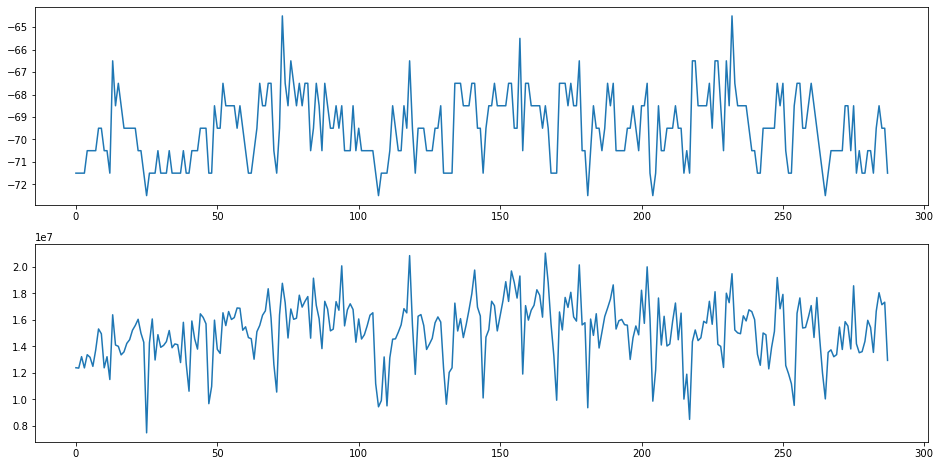

In [19]:
#x axis of time; top is longitude, bottom is net volume over time 
fig, axs = pltt.subplots(2, figsize=(16,8))
axs[0].plot(istar2)
axs[1].plot(volume_over_time)

In [9]:
#Ensure that the total volume at istar is the total volume on top of the band 
volume_at_istar = tr.where(tr.i < istar1).sum('i')
# volume_at_istar.load()

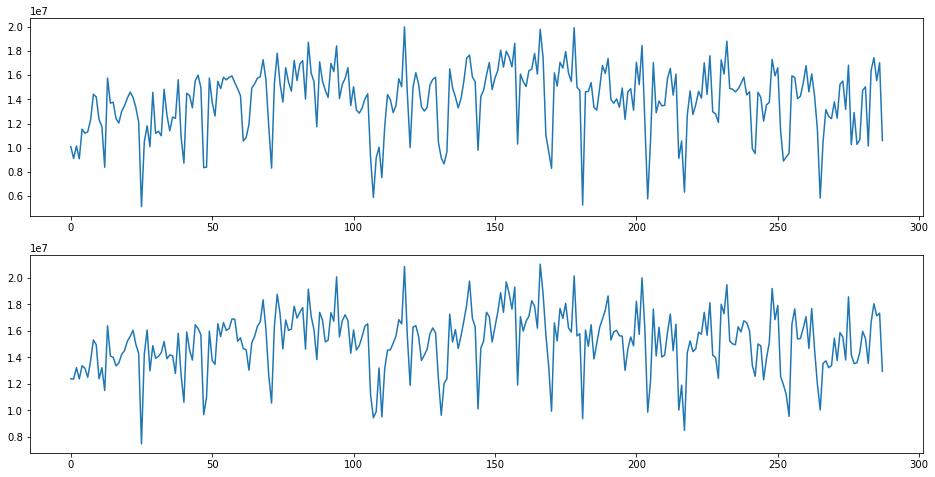

In [80]:
fig, axs = pltt.subplots(2, figsize=(16,8))
axs[0].plot(volume_at_istar)
axs[1].plot(volume_over_time)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


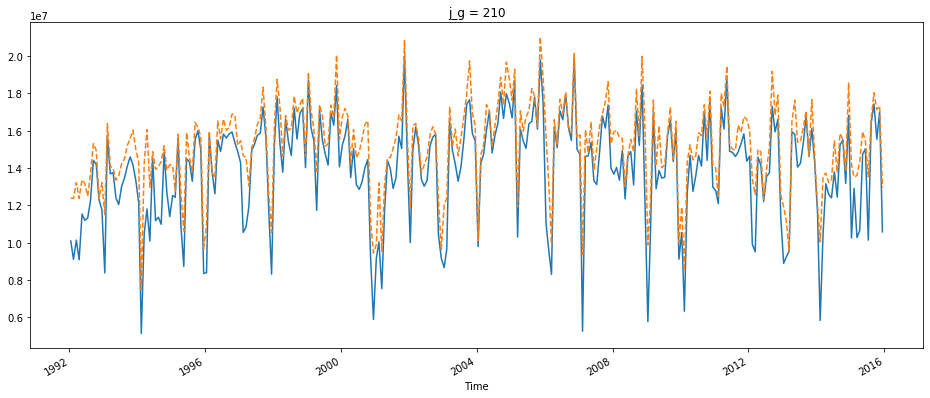

In [13]:
fig, ax = pltt.subplots(figsize=(16,6))
(volume_at_istar).plot(ax=ax)
(volume_over_time).plot(ax=ax, ls='--')

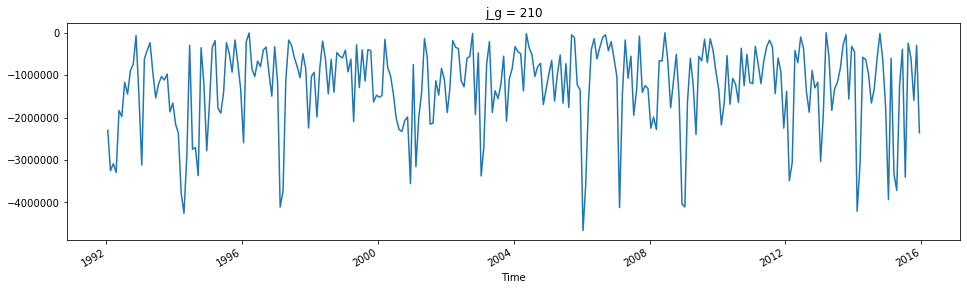

In [84]:
(volume_at_istar - volume_over_time).plot(figsize=(16,4))
#seems like volume at istar is smaller than volume over time at large?

In [ ]:
#Interpolation
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

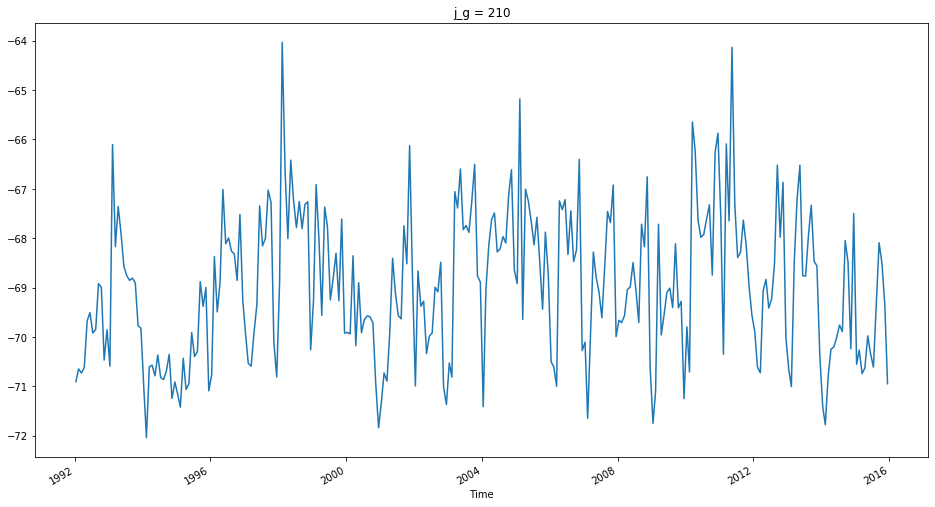

In [52]:
smooth_longitude =  ratio + istar2
smooth_longitude.plot(figsize=(16,8))

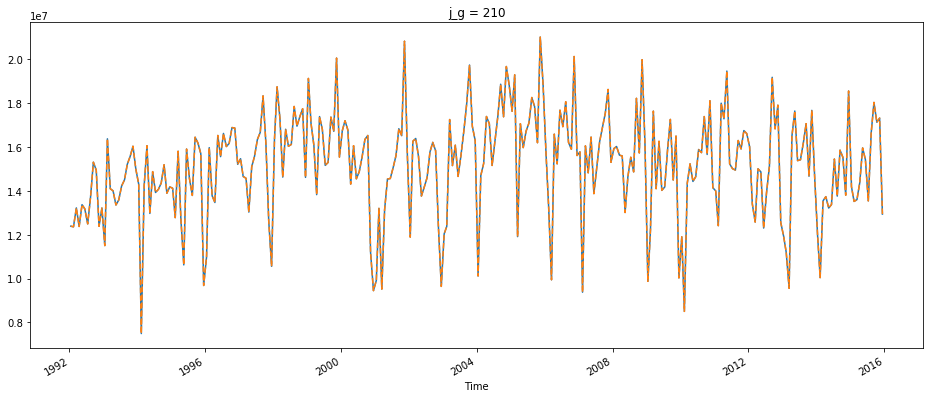

In [65]:
#check that interpolated matches net 
volume_in_cell = ratio*difference 
interpolated_volume = volume_at_istar + volume_in_cell
fig, ax = pltt.subplots(figsize=(16,6))
(volume_over_time).plot(ax=ax)
(interpolated_volume).plot(ax=ax, ls='--')

In [10]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, 210, :] #(time, l3_c, i)

In [13]:
istar3 = istar1 + 1
#top left and right
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])

adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])

bottom = a[:, 101:, :].sum(['l3_c', 'i'])

nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

In [14]:
#Compute the next cell's advection - top left  
adv_nextcell = a.where(a.i < istar3)[:, :101, :].sum(['i','l3_c'])
adv_difference = adv_nextcell - top_left 
adv_topleft = ratio * adv_difference + top_left

In [15]:
#top right 
adv_nextcell = a.where(a.i >= istar3)[:, :101, :].sum(['i','l3_c']) 
adv_difference = adv_nextcell - top_right
adv_topright = ratio*adv_difference + top_right

In [16]:
#bottom
bottom = a[:, 101:, :].sum(['l3_c', 'i'])

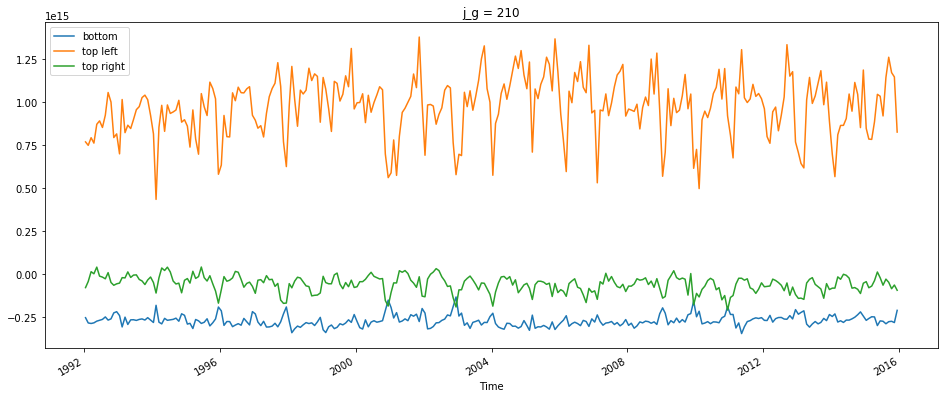

In [72]:
fig, ax = pltt.subplots(figsize=(16,6))
(bottom).plot(ax=ax)
(adv_topleft).plot(ax=ax)
(adv_topright).plot(ax=ax)
ax.legend(("bottom", "top left", "top right"),loc='upper left')

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


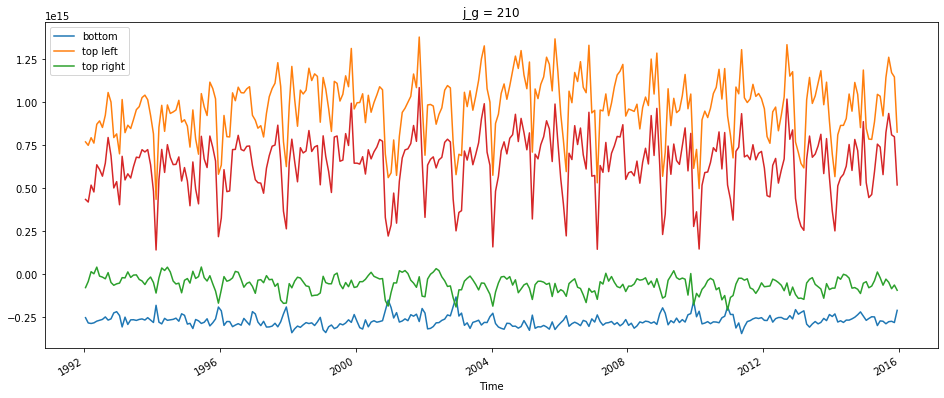

In [17]:
adv_net = adv_topright + adv_topleft + bottom

fig, ax = pltt.subplots(figsize=(16,6))
(bottom).plot(ax=ax)
(adv_topleft).plot(ax=ax)
(adv_topright).plot(ax=ax)
(adv_net).plot(ax=ax)
ax.legend(("bottom", "top left", "top right"),loc='upper left')

In [35]:
#Through the face j_g=210; corresponds with mht_A_semester
advy = ds.VVELMASS[:, :, 215] * ds.THETA[:, :, 215] * coords.drF * coords.dxG[215, :] * ds.atl_maskS[215, :]
f =(advy[:,:,136:230]*rho0*cp).sum(['i','k'])
mean_face =(f*ds.dt).sum('time')/(ds.dt.sum('time')) 
face = ((f-mean_face)*ds.dt).cumsum('time')

(-1.2e+22, 1.2e+22)

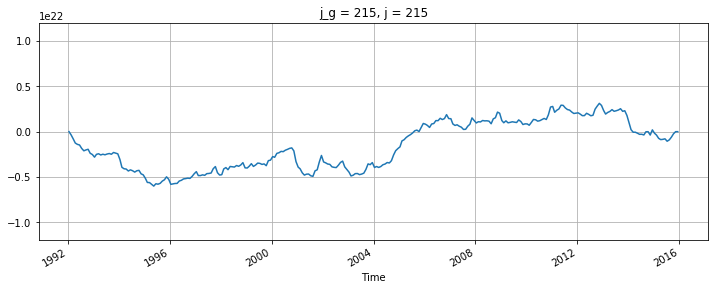

In [36]:
#Plot through the one face 
pltt.figure(figsize=(12,4))
pltt.grid()
face.plot()
pltt.ylim(-1.2*10**22,1.2*10**22)

In [33]:
#Through the face j_g=210; corresponds with mht_A_semester
advy = ds.VVELMASS[:, :, 220] * ds.THETA[:, :, 220] * coords.drF * coords.dxG[220, :] * ds.atl_maskS[220, :]
f =(advy[:,:,136:230]*rho0*cp).sum(['i','k'])
mean_face =(f*ds.dt).sum('time')/(ds.dt.sum('time')) 
face = ((f-mean_face)*ds.dt).cumsum('time')

(-1.2e+22, 1.2e+22)

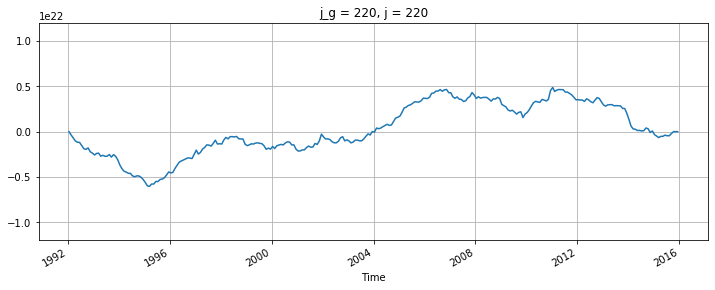

In [34]:
#Plot through the one face 
pltt.figure(figsize=(12,4))
pltt.grid()
face.plot()
pltt.ylim(-1.2*10**22,1.2*10**22)

In [37]:
#Check if j_g=215 would work 
#Understanding: the north face of the box has much less variability, so we want to make sure the south face (210 , 215) looks a little
#more like mht_A to ensure we can still say that the south face variability mostly determines flux through the whole box 
#j_g=210 does not look a lot like the whole box but 215 looks much better, so we're going to check if the find istar method 
#works for it as well

In [49]:
#Makes array of total volume transport above sigma=101 in the basin as a function of time, at latitude 215
tr_215 = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, 215, :].sum('l3_c') #at j_g = 210, up to sigma = 101
volume_over_time215 = tr.sum('i') 

#Makes array of i-star at each time 
volume_over_i215 = tr_215.cumsum('i')[:, 110:180] - v_over_t215
istar_215 = np.argmax((volume_over_i>0)[:, :],axis=1) #largest

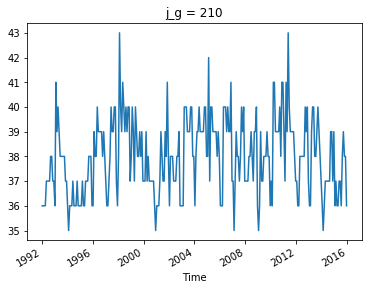

In [55]:
istar_215.plot()

<xarray.DataArray (i: 70)>
dask.array<sub, shape=(70,), dtype=float64, chunksize=(70,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1992-01-15
  * i        (i) int64 110 111 112 113 114 115 116 ... 174 175 176 177 178 179
    dt       float64 nan